This notebook is an exercise in sentiment classification and provides an emoji for a sentence. The training dataset contains 127 sentences with the output containing integer labels between 0 and 4 corresponding to an emoji for each sentence. The output from the neural network is a probability vector of shape (1,5) which is passed to an argmax layer which then extracts the index of the emoji with the highest probability. 

<center>
<img src="images/image_1.png" style="width:900px;height:300px;">
<caption><center> Baseline model (Emojifier).</center></caption>
</center>

In [1]:
import numpy as np
from emoutils import *
import emoji
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
maxLen = len(max(X_train, key=len).split())

In [4]:
Y_oh_train = convert_to_one_hot(Y_train, C = 5)
Y_oh_test = convert_to_one_hot(Y_test, C = 5)

In [5]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('models/glove.6B.50d.txt')

In [6]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    
    # Split sentence into list of lower case words
    words = [word.lower() for word in sentence.split()]

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(word_to_vec_map[words[0]].shape)
    
    # Average the word vectors. Can loop over the words in the list "words".
    total = np.zeros(word_to_vec_map[words[0]].shape)
    for w in words:
        total += word_to_vec_map[w]
    avg = total/float(len(words))
    
    
    return avg

In [7]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    
    np.random.seed(1)

    # Define number of training examples
    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,))
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y, C = n_y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W, avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = -np.sum(np.multiply(Y_oh[i], np.log(a)))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map) #predict is defined in emoutils.py

    return pred, W, b

In [8]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)

Epoch: 0 --- cost = 1.9520498812810072
Accuracy: 0.3484848484848485
Epoch: 100 --- cost = 0.07971818726014807
Accuracy: 0.9318181818181818
Epoch: 200 --- cost = 0.04456369243681402
Accuracy: 0.9545454545454546
Epoch: 300 --- cost = 0.03432267378786059
Accuracy: 0.9696969696969697


In [9]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.9772727272727273
Test set:
Accuracy: 0.8571428571428571


(56,)
           ❤️    ⚾    😄    😞   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


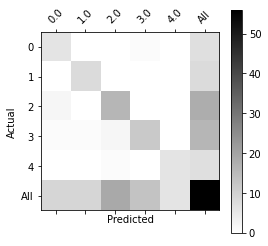

In [21]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

Emojifier-V2 will be able to account for the word ordering. This will continue to use pre-trained word embeddings to represent words. The word embeddings will be fed into an LSTM. The LSTM will learn to predict the most appropriate emoji.

<img src="images/emojifier-v2.png" style="width:700px;height:400px;"> <br>
<caption><center> Emojifier-V2. A 2-layer LSTM sequence classifier. </center></caption>

In [10]:
import numpy as np
np.random.seed(0)
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
np.random.seed(1)

Using TensorFlow backend.


In [11]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
   
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words to get a list of words.
        sentence_words = X[i].lower().split()
        
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            X_indices[i, j] = word_to_index[w]
            j = j + 1
            
    
    return X_indices

In [12]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "idx" of the embedding matrix to be the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
   
    # Define Keras embedding layer with the correct input and output sizes. Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) 
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [13]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [14]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape=input_shape, dtype='int32' )
    
    # Create the embedding layer pretrained with GloVe Vectors
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)  
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state. The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state. The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense(5, activation=None)(X)
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    return model

In [15]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
__________

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train, C = 5)

In [18]:
model.fit(X_train_indices, Y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
132/132 [==============================] - 1s 4ms/step - loss: 1.6083 - acc: 0.1970
Epoch 2/50
132/132 [==============================] - 0s 861us/step - loss: 1.5324 - acc: 0.2955
Epoch 3/50
132/132 [==============================] - 0s 816us/step - loss: 1.5011 - acc: 0.3258
Epoch 4/50
132/132 [==============================] - 0s 824us/step - loss: 1.4391 - acc: 0.3561
Epoch 5/50
132/132 [==============================] - 0s 839us/step - loss: 1.3481 - acc: 0.4545
Epoch 6/50
132/132 [==============================] - 0s 796us/step - loss: 1.2347 - acc: 0.5152
Epoch 7/50
132/132 [==============================] - 0s 831us/step - loss: 1.1768 - acc: 0.4470
Epoch 8/50
132/132 [==============================] - 0s 854us/step - loss: 1.0552 - acc: 0.5758
Epoch 9/50
132/132 [==============================] - 0s 839us/step - loss: 0.8780 - acc: 0.7121
Epoch 10/50
132/132 [==============================] - 0s 846us/step - loss: 0.8241 - acc: 0.6970
Epoch 11/50
132/132 [==========

In [19]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test, C = 5)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

56/56 [==============================] - 0s 2ms/step

Test accuracy =  0.8214285629136222


In [20]:
C = 5
y_test_oh = np.eye(C)[Y_test.reshape(-1)]
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
pred = model.predict(X_test_indices)
for i in range(len(X_test)):
    x = X_test_indices
    num = np.argmax(pred[i])
    if(num != Y_test[i]):
        print('Expected emoji:'+ label_to_emoji(Y_test[i]) + ' prediction: '+ X_test[i] + label_to_emoji(num).strip())

Expected emoji:😄 prediction: she got me a nice present	❤️
Expected emoji:😞 prediction: work is hard	😄
Expected emoji:😞 prediction: This girl is messing with me	❤️
Expected emoji:🍴 prediction: any suggestions for dinner	😄
Expected emoji:❤️ prediction: I love taking breaks	😞
Expected emoji:😄 prediction: you brighten my day	❤️
Expected emoji:😄 prediction: will you be my valentine	❤️
Expected emoji:🍴 prediction: See you at the restaurant	😄
Expected emoji:😞 prediction: go away	⚾
Expected emoji:🍴 prediction: I did not have breakfast ❤️
